# Relationship between object and lens orientation angles in Scheimpflug imaging

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import sympy as sy

In [2]:
%matplotlib inline

In [3]:
# Helper functions
sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))
arcsind = lambda x : np.rad2deg(np.arcsin(x))
arccosd = lambda x : np.rad2deg(np.arccos(x))
arctand = lambda x : np.rad2deg(np.arctan(x))

# Helper function for saving figures
curDir = os.getcwd()
imgdir = os.path.join(curDir, 'images')
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    print("Created 'images' directory")


bSaveFigure = True
fig_format, fig_ext = 'png', '.png'
def saveFigure(figure, fig_name, DPI=120):
    if bSaveFigure:
        figname = os.path.join(imgdir, fig_name)
        print('figname:', figname)
        figure.savefig(figname, dpi=DPI, facecolor='white', edgecolor='white',
                       bbox_inches='tight', format=fig_format, pad_inches=0.03)

## Rotation of lens about a pivot away from the ENPP

If the object plane is tilted about one axis (let's say the x-axis) by and angle $\beta$ (such that, it makes angle $\beta$ w.r.t. the vertical, y-axis), then the lens must also be rotated in the same direction (i.e. about the x-axis). If the angle of rotation of the lens is $\alpha$, then in order for the tilted object to be in focus, $\alpha$ and $\beta$ must satisfy the following relationship:

$$
\tan \,\beta = -\frac{\sin \,\alpha \left[ m_p(z_o - d_e \cos \,\alpha) + f(1-m_p) \cos \,\alpha \right]}{(f - m_p d_e \sin^2 \alpha)(m_p \cos^2 \alpha + \sin^2 \alpha)+m_p(1-m_p)d_e \sin^2 \alpha \, \cos^2 \alpha}
$$

We will often refer to the R.H.S. of the above equation as $F(\alpha)$.

#### Lens rotated about a changing pivot point

In [25]:
# Functions for analysing the effects of lens rotation

def get_beta_shifting_pivot(x, de, zo, f, mp, alpha):
    """compute the object tilt angle (orientation of PoSF) for lens tilted about the x-axis
    about a point (de + x) distance from the ENPP. 
    
    @param: x: increment in distance of ENPP from {C} in fronto-parallel configuration
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: zo: directed distance of object plane from {C} 
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    """
    c = cosd(alpha)
    s = sind(alpha)
    numr = s*( mp*(zo + x - (de + x)*c) + f*(1 - mp)*c)
    deno = (f - mp*(de + x)*s**2)*(mp*c**2 + s**2) + (de + x)*mp*(1-mp)*(s**2)*(c**2)
    return -arctand(numr/deno)

def get_beta(de, zo, f, mp, alpha):
    """compute the object tilt angle (orientation of PoSF) for lens tilted about the x-axis
    about a point (de) distance from the ENPP. 
    
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: zo: directed distance of object plane from {C} 
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    """
    return get_beta_shifting_pivot(0.0, de, zo, f, mp, alpha)

def get_zoDash(zo, alpha, beta, f, mp, de, deDash):
    """compute image plane distance (along z-axis of {C})
    
    @param: zo: directed distance of object plane from {C} 
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    @param: beta: angle of rotation (in degrees) of the object plane about it's pivot about x-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: deDash: directed distance of EXPP from {C} in fronto-parallel configuration.
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = tand(beta)
    z = zo - de*(s*t + c)
    numr = mp*f*(mp*c**2 + s**2)*z
    deno = mp*c*z + f
    return deDash*c + numr/deno

def get_tanBeta(de, zo, f, mp, alpha):
    """same as the function `get_beta()`, except that it returns tan(beta) instead of beta
    """
    c = cosd(alpha)
    s = sind(alpha)
    numr = -s*(mp*(zo - de*c) + f*(1 - mp)*c)
    deno = (f - mp*de*s**2)*(mp*c**2 + s**2) + de*mp*(1-mp)*(s**2)*(c**2)
    return numr/deno

def beta_thin(zo, f, alpha):
    """compute beta using thin-lens approximation. If the lens is rotated about the ENPP
    and the pupil magnification equals one, then this relation is exact too.
    """
    return -arctand(zo*sind(alpha)/f)

In [6]:
# ex. optical system "paraxialDoubleLens24mmFiniteConj_mp2.zmx"
zo = -509.0
f = 24.0
mp = 2.0
de = -5.0        # along the optical axis
deDash = -25.0   # along the optical axis

#Image position (zoDash): 24.1707317
#Obj. distance from ENPP (|ze|): 504.0
#Image position from EXPP (|zeDash|): 49.1707316951

# First we ensure that the object-to-ENPP distance (ze) and EXPP-to-image distance (zeDash)
# remains fixed in frontoparallel configuration for different values of x.
alpha = 0
for x in range(3):
    zoNew = zo + x
    deNew = de + x
    deDashNew = deDash + x
    ze = zoNew - deNew*cosd(alpha)
    # since the function get_zoDash computes zoNew, and deNew we just pass zo and de (the initial values)
    beta = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alpha) 
    zoDash = get_zoDash(zo=zoNew, alpha=alpha, beta=beta, f=f, mp=mp, de=deNew, deDash=deDashNew)
    zeDash = zoDash - deDashNew*cosd(alpha)
    print(('zo = {:3.2f}, zoDash = {:3.2f}, d = {:3.2f}, ze = {:3.2f}, zeDash = {:3.2f}'
           .format(zoNew, zoDash, deDashNew - deNew, ze, zeDash)))

zo = -509.00, zoDash = 24.17, d = -20.00, ze = -504.00, zeDash = 49.17
zo = -508.00, zoDash = 25.17, d = -20.00, ze = -504.00, zeDash = 49.17
zo = -507.00, zoDash = 26.17, d = -20.00, ze = -504.00, zeDash = 49.17


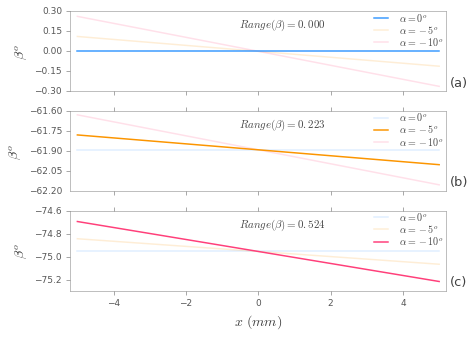

In [8]:
alphaArr = [0, -5, -10]

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8*0.8, 6*0.8))
(ax0, ax1, ax2) = axes.flatten()

x = np.linspace(-5, 5, 21)
beta0 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[0])
beta1 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[1])
beta2 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[2])
beta0Mean = np.mean(beta0)
beta1Mean = np.mean(beta1)
beta2Mean = np.mean(beta2)

rangeBeta0 = '{:0.3f}'.format(np.max(beta0) - np.min(beta0))
rangeBeta1 = '{:0.3f}'.format(np.max(beta1) - np.min(beta1))
rangeBeta2 = '{:0.3f}'.format(np.max(beta2) - np.min(beta2))

# figure  (the figure and font size in the figure are optimized for saving for embedding into word)
#print(beta0Mean, beta1Mean, beta2Mean)
alphaLight = 0.16
lwLight = 1.5
lwEmph = 1.5

ax0.plot(x, beta0, color='#3A9AFF', lw=lwEmph, 
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=10)
ax0.plot(x, beta1 - beta1Mean,  color='#FC9500', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=8)
ax0.plot(x, beta2 - beta2Mean, color='#FF3F7A', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=8)
ax0.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta0), fontsize=11, transform=ax0.transAxes)
#
ax1.plot(x, beta0 + beta1Mean, color='#3A9AFF', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=8)
ax1.plot(x, beta1, color='#FC9500', lw=lwEmph,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=10)
ax1.plot(x, beta2 + (beta1Mean - beta2Mean), color='#FF3F7A', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=8)
ax1.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta1), fontsize=11, transform=ax1.transAxes)
#
ax2.plot(x, beta0 + beta2Mean, color='#3A9AFF', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=8)
ax2.plot(x, beta1 + (beta2Mean - beta1Mean), color='#FC9500', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=8)
ax2.plot(x, beta2, color='#FF3F7A', lw=lwEmph,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=10)
ax2.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta2), fontsize=11, transform=ax2.transAxes)

# plot decorations
# common to all axes
for l, ax in zip(['(a)', '(b)', '(c)'], [ax0, ax1, ax2]):
    ax.set_xlim(x[0]-0.2, x[-1] + 0.2)                # x limit
    #ax.grid(axis='y', alpha=0.4)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))    # number of ticks
    ax.yaxis.set_ticks_position('left')               # tick 
    ax.set_ylabel(r'$\beta^o$', fontsize=14)          # y-label
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
    # legend
    ax.legend(loc=(0.79, 0.5), labelspacing=0.008, fontsize=10)
    # subplot id label  
    ax.text(1.01, 0.065, l, fontsize=13, color='#404040', transform=ax.transAxes)
    
ax0.xaxis.set_ticks_position('bottom')
ax2.set_xlabel(r'$x\,\,(mm)$', fontsize=14)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'object_tilt_angle_with_pivot_movement.png')

plt.show()

<font color='red'>**Question**</font> For given $\alpha$ do we always get unique $\beta$?

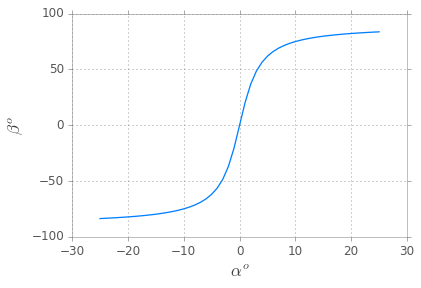

In [11]:
# plot of alpha vs. beta  
# this plot shows that given alpha, we can get a unique beta within +/-90°
alpha = np.linspace(-25., 25., 51)
beta = get_beta(de=-5.0, zo=-509.0, f=24.0, mp=2.0, alpha=alpha)

plt.plot(alpha, beta)
plt.xlabel(r'$\alpha^o$', fontsize=17)
plt.ylabel(r'$\beta^o$', fontsize=17)
plt.grid()
plt.show()

The above plot seems to suggest that we get unique $\beta$ for a given $\alpha$. But .... 

As we can see in the figures below, $F(\alpha)$ <font color='red'>**may not be monotonic**</font>. Therefore, we might end up getting multiple values of $\beta$ (and $\tan \,\beta$) for the same value of $\alpha$. So, there are some combinations of the optical system parameters that makes $F(\alpha)$ non-monotonic.

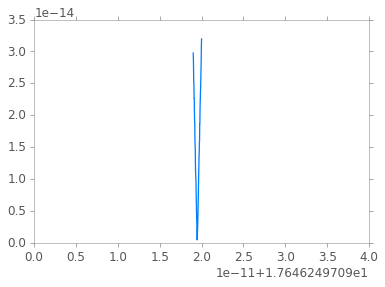

3.1330701123 3.1330701123 72.298177969


In [19]:
# emperically find alpha values for which we get same value of beta 
# Here, I manually found the second alpha by minimized the error visually!

zo=-509.0
f = 24.0
de=-5.0

mp=0.15; alpha=45
#mp=0.1; alpha=15

tBeta0 = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
#alphaArr = np.linspace(33.837970239821, 33.837970239825) # for mp=0.1; alpha=15
alphaArr = np.linspace(17.646249708999, 17.646249709)   # for mp=0.15; alpha=45
absErr = []
for each in alphaArr:
    tBeta1 = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=each)
    absErr.append(abs(tBeta1 - tBeta0))

absErr = np.array(absErr)

plt.plot(alphaArr, absErr)
plt.show()

print(get_tanBeta(de=de, zo=zo, f=f, mp=0.15, alpha=17.646249709), 
      get_tanBeta(de=de, zo=zo, f=f, mp=0.15, alpha=45.0), 
      get_beta(de=de, zo=zo, f=f, mp=0.15, alpha=45))

#print(get_tanBeta(de=de, zo=zo, f=f, mp=0.1, alpha=15.0), 
#      get_tanBeta(de=de, zo=zo, f=f, mp=0.1, alpha=33.837970239821), 
#      get_beta(de=de, zo=zo, f=f, mp=0.1, alpha=15))

# Emperically found
# for mp=0.15; alpha=17.646249709, 45; tanbeta = 3.1330701123; beta = 72.298177969
# for mp=0.1; alpha=15.0, 33.837970239821; tanbeta = 2.00014403634; beta = 63.4365992627

The following plots demonstrates that for some values of $m_p$ (or perhaps, for certain combination of lens parameters $m_p$, $f$, $d_e$ and object distance $z_o$), the plot of $F(\alpha)$ (and therefore $\beta$) is not monotonic for increasing values of $\alpha$. 

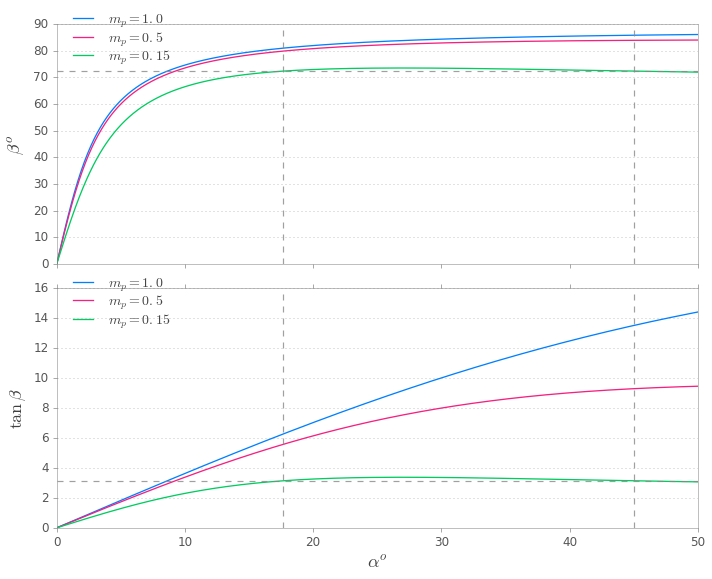

In [21]:
# plot of alpha vs. beta 
# this plot shows that given alpha, we MAY NOT get a unique beta within +/-90°
zo=-509.0
f = 24.0
de=-5.0

alpha = np.linspace(0., 50., 1000)
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

for i, mp in enumerate([1.0, 0.5, 0.15,]):
    beta = get_beta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
    tBeta = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, beta, label=legTxt)
    ax1.plot(alpha, tBeta, label=legTxt)
    
# plot the non-unique alpha, beta points for illustration
# These values were emperically found
# for mp=0.15; alpha=17.646249709, 45; tanbeta = 3.1330701123; beta = 72.298177969
ax0.axhline(72.298177969, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axhline(3.1330701123, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(17.646249709, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(45.0, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axvline(17.646249709, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axvline(45.0, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
# for mp=0.1; alpha=15.0, 33.837970239821; tanbeta = 2.00014403634; beta = 63.4365992627
#ax0.axhline(63.4365992627)
#ax1.axhline(2.00014403634)

# plot decorations
for ax in [ax0, ax1]:
    ax.grid(axis='y', alpha=0.6)
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))    # number of ticks
    ax.yaxis.set_ticks_position('left')                # tick
    ax.legend(loc=(0.01, 0.8), labelspacing=0.008, fontsize=14)   #TODO:: fix legend ... place single legend
                                                                  #       between the subplots
ax0.xaxis.set_ticks_position('bottom')
ax1.set_xlabel(r'$\alpha^o$', fontsize=18)
ax0.set_ylabel(r'$\beta^o$', fontsize=18)
ax1.set_ylabel(r'$\rm{tan}\, \beta$', fontsize=18)

fig.tight_layout()

plt.show()

So, now we need to answer the following **two questions**:

(1) How can we detect the situation when multiple (probably just two) $\alpha$ for which we get the same $\beta$?

(2) Can we find an algebraic expression (a function of the relevant optical parameters) for the condition?

In order to answer (1), we can take the derivative of $F(\alpha)$ w.r.t. $\alpha$ and find out if the derivative, $F'(\alpha)$, is always positive (monotonically increasing) or always negative (monotonically decreasing) with an interval $[a, b]$. If $F'(\alpha)$ changes sign within the chosen interval $[a, b]$, then $F(\alpha)$ is not monotonic. In other words, if we can find real roots of $F'(\alpha)$, then $F(\alpha)$ is not monotonic. 

We will find the derivative using SymPy.

In [10]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a, mp, zo, f, de = sy.symbols('alpha, m_p, z_o, f, d_e', real=True)
numr = -sy.sin(a)*(mp*(zo - de*sy.cos(a)) + f*(1 - mp)*sy.cos(a))
deno = (f - mp*de*sy.sin(a)**2)*(mp*sy.cos(a)**2 + sy.sin(a)**2) + mp*(1-mp)*de*sy.sin(a)**2*sy.cos(a)**2
expr = numr/deno
expr

              -(f⋅(-m_p + 1)⋅cos(α) + m_p⋅(-dₑ⋅cos(α) + zₒ))⋅sin(α)           
──────────────────────────────────────────────────────────────────────────────
                     2       2      ⎛       2         2   ⎞ ⎛            2    
dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p⋅sin (α) 

    
────
   ⎞
+ f⎠

In [11]:
sy.diff(expr, a)

                                                                              
                     (dₑ⋅m_p⋅sin(α) - f⋅(-m_p + 1)⋅sin(α))⋅sin(α)             
- ────────────────────────────────────────────────────────────────────────────
                       2       2      ⎛       2         2   ⎞ ⎛            2  
  dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p⋅sin (α
                                                                              

                                                                              
                        (f⋅(-m_p + 1)⋅cos(α) + m_p⋅(-dₑ⋅cos(α) + zₒ))⋅cos(α)  
────── - ─────────────────────────────────────────────────────────────────────
     ⎞                        2       2      ⎛       2         2   ⎞ ⎛        
) + f⎠   dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p
                                                                              

                                                  

Well ... well ... well! That is getting a little too complicated. Let's abandon it for now, and examine the more relevant case of rotating the lens about the ENPP, which we expect to be simpler. If we find a useful strategy, then we can come back and apply the same strategy here.

## Lens rotated about the x-axis at ENPP

If the lens is rotated about the ENPP ($d_e = 0$), the expression for $\tan \,\beta$ (or equivalently the expression for $F(\alpha)$) reduces to:

$$
tan \,\beta = F(\alpha) =
- \frac{\sin\,\alpha \left( m_p z_o +  f \left(1 - m_p \right) \cos \,\alpha \right)}{f \left(m_p \cos^2\alpha + \sin^2\alpha \right)}
$$

As before, we will find the derivative using SymPy.

In [22]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a, mp, zo, f, de = sy.symbols('alpha, m_p, z_o, f, d_e', real=True)
numr = -sy.sin(a)*(mp*zo + f*(1 - mp)*sy.cos(a))
deno = f*(mp*sy.cos(a)**2 + sy.sin(a)**2)
expr = numr/deno
expr

-(f⋅(-m_p + 1)⋅cos(α) + m_p⋅zₒ)⋅sin(α) 
───────────────────────────────────────
         ⎛       2         2   ⎞       
       f⋅⎝m_p⋅cos (α) + sin (α)⎠       

In [23]:
firstDeri = sy.diff(expr, a)
firstDeri

                2                                                             
  (-m_p + 1)⋅sin (α)    (f⋅(-m_p + 1)⋅cos(α) + m_p⋅zₒ)⋅cos(α)   (f⋅(-m_p + 1)⋅
───────────────────── - ───────────────────────────────────── - ──────────────
       2         2              ⎛       2         2   ⎞                       
m_p⋅cos (α) + sin (α)         f⋅⎝m_p⋅cos (α) + sin (α)⎠                       
                                                                              

                                                               
cos(α) + m_p⋅zₒ)⋅(2⋅m_p⋅sin(α)⋅cos(α) - 2⋅sin(α)⋅cos(α))⋅sin(α)
───────────────────────────────────────────────────────────────
                                     2                         
              ⎛       2         2   ⎞                          
            f⋅⎝m_p⋅cos (α) + sin (α)⎠                          

In [24]:
firstDeri = sy.simplify(firstDeri)
firstDeri

     2    2                   2             2       3           2             
f⋅m_p ⋅cos (α) - f⋅m_p - f⋅cos (α) + f + m_p ⋅zₒ⋅cos (α) - 2⋅m_p ⋅zₒ⋅cos(α) - 
──────────────────────────────────────────────────────────────────────────────
                                                                  2           
                                           ⎛       2         2   ⎞            
                                         f⋅⎝m_p⋅cos (α) + sin (α)⎠            

          3                   
m_p⋅zₒ⋅cos (α) + m_p⋅zₒ⋅cos(α)
──────────────────────────────
                              
                              
                              

In [136]:
x = sy.symbols('x', real=True)
firstDeri = firstDeri.subs({sy.cos(a):x})
firstDeri

     2  2              2          2  3           2             3              
f⋅m_p ⋅x  - f⋅m_p - f⋅x  + f + m_p ⋅x ⋅zₒ - 2⋅m_p ⋅x⋅zₒ - m_p⋅x ⋅zₒ + m_p⋅x⋅zₒ
──────────────────────────────────────────────────────────────────────────────
                                                2                             
                              ⎛     2      2   ⎞                              
                            f⋅⎝m_p⋅x  + sin (α)⎠                              

In [80]:
def compute_zoDash(zo, f, mp, d, alpha):
    """formula for computing the image plane distance from the pivot (origin of {C}) if
    lens is tilted about the ENPP. That is de=0, deDash = d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: d: distance from ENPP to EXPP
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    """
    c = cosd(alpha)
    s = sind(alpha)
    return d*c + mp*f*zo*(mp*c**2 + s**2)/(zo*mp*c + f)

def get_beta(zo, f, mp, alpha):
    """formula for computing the object plane tilt angle if
    lens is tilted about the ENPP. That is de=0, deDash = d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return arctand(t)

def get_tanBeta(zo, f, mp, alpha):
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return t



def first_derivative(zo, f, mp, alpha):
    """evaluate the first derivative of the RHS of the function giving tan(beta) = RHS
    """
    a = mp*zo*(mp-1)
    b = f*(mp**2 - 1)
    c = mp*zo*(1-2*mp)
    d = f*(1-mp)
    numr = a*cosd(alpha)**3 + b*cosd(alpha)**2 + c*cosd(alpha) + d
    deno = f*(mp*cosd(alpha)**2 + sind(alpha))**2
    firstDeri = numr/deno
    return firstDeri

def get_roots_first_derivative(zo, f, mp):
    a = mp*zo*(mp-1)
    b = f*(mp**2 - 1)
    c = mp*zo*(1-2*mp)
    d = f*(1-mp)
    roots = np.roots([a, b, c, d])
    return roots

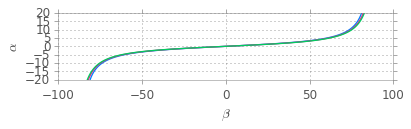

In [16]:
zo = -509.0
f = 24.0
mpArr = [0.55, 1, 2.0]

alpha = np.linspace(-20, 20, 101)

fig, ax = plt.subplots(1,1)

for mp in mpArr:
    beta = get_beta(zo, f, mp, alpha)
    ax.plot(beta, alpha)
    

# No need to plot beta_thin ... this is same as mp=1    
#betaT = beta_thin(zo, f, alpha)
#ax.plot(betaT, alpha, 'k-')

ax.grid()
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$\beta$')
ax.set_aspect('equal')
plt.show()

In [17]:
# emperically find alphas for which we get multiple values of beta 

zo=-509.0
f = 24.0

#mp=0.15; alpha=45
#mp=0.1; alpha=15
#
#tBeta0 = get_tanBeta(zo=zo, f=f, mp=mp, alpha=45)
#alphaArr = np.linspace(18.0188354928516, 18.0188354928517)
#absErr = []
#for each in alphaArr:
#    tBeta1 = get_tanBeta(zo=zo, f=f, mp=mp, alpha=each)
#    absErr.append(abs(tBeta1 - tBeta0))

#absErr = np.array(absErr)

#plt.plot(alphaArr, absErr)
#plt.show()

print(get_tanBeta(zo=zo, f=f, mp=0.15, alpha=18.0188354928516), 
      get_tanBeta(zo=zo, f=f, mp=0.15, alpha=45.0), 
      get_beta(zo=zo, f=f, mp=0.15, alpha=45))

# Emperically found
# for mp=0.15; alpha=18.0188354928516, 45; tanbeta = 3.17301469156; beta = 72.5073533271

3.17301469156 3.17301469156 72.5073533271


TypeError: get_beta() takes exactly 6 arguments (4 given)

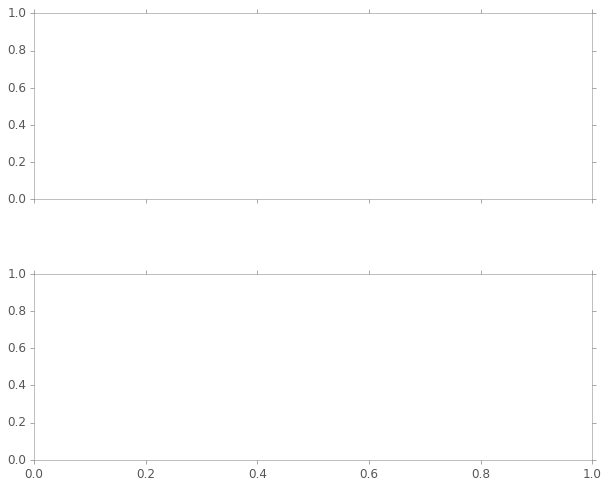

In [167]:
# plot of alpha vs. beta 
# this plot shows that given alpha, we MAY NOT get a unique beta within +/-90°
zo=-509.0
f = 24.0

alpha = np.linspace(0., 50., 1000)
fig, (ax0, ax1,) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
#fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, mp in enumerate([0.5, 0.15, ]):
    beta = get_beta(zo=zo, f=f, mp=mp, alpha=alpha)
    tBeta = get_tanBeta(zo=zo, f=f, mp=mp, alpha=alpha)
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, beta, label=legTxt)
    ax1.plot(alpha, tBeta, label=legTxt)
    #ax2.plot(alpha, first_derivative(zo, f, mp, alpha))
    
# plot the non-unique alpha, beta points for illustration
# These values were emperically found
# for mp=0.15; alpha=18.0188354928516, 45; tanbeta = 3.17301469156; beta = 72.5073533271
ax0.axhline(72.5073533271, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axhline(3.17301469156, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(18.0188354928516, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax0.axvline(45.0, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axvline(18.0188354928516, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axvline(45.0, color='#888888', alpha=0.8, lw=1.2, linestyle='dashed')
#ax2.axhline(color='#555555', alpha=0.8, lw=1.2, linestyle='dashed')

# plot decorations
#ax2.set_ylim(-1.5, 21)
for ax in [ax0, ax1, ax2]:
    ax.grid(axis='y', alpha=0.6)
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))    # number of ticks
    ax.yaxis.set_ticks_position('left')               # tick

#ax.legend(loc=(0.01, 0.8), labelspacing=0.008, fontsize=14)
ax0.xaxis.set_ticks_position('bottom')
ax1.set_xlabel(r'$\alpha^o$', fontsize=18)
ax0.set_ylabel(r'$\beta^o$', fontsize=18)
ax1.set_ylabel(r'$\rm{tan}\, \beta$', fontsize=18)
#ax2.set_ylabel(r'$d/dx \, [F(\alpha)]$')

fig.tight_layout()

plt.show()

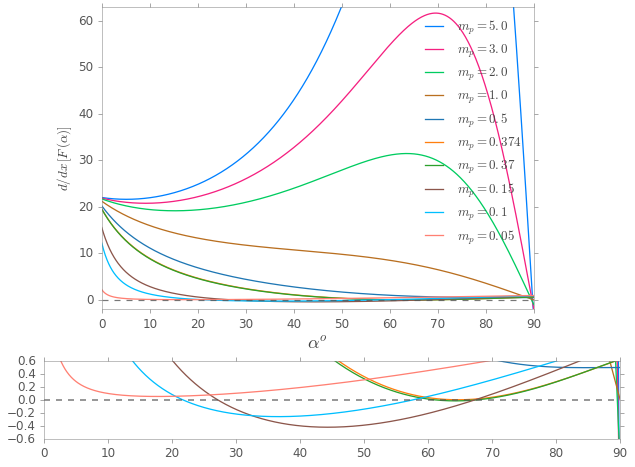

In [166]:
# plot of the first derivative

zo=-509.0
f = 24.0
#fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 11))
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_axes([0.1, 0.3, 0.75, 0.7])  # [*left*, *bottom*, *width*, *height*]
ax1 = fig.add_axes([0.0, 0.0, 1.0, 0.18,])
alpha = np.linspace(0., 89.9999, 1000)
for i, mp in enumerate([5.0, 3.0, 2.0, 1.0, 0.5, 0.374, 0.37, 0.15, 0.1, 0.05]):
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, first_derivative(zo, f, mp, alpha), label=legTxt)
    ax1.plot(alpha, first_derivative(zo, f, mp, alpha))

ax0.axhline(color='#555555', alpha=0.8, lw=1.2, linestyle='dashed')
ax1.axhline(color='#555555', alpha=0.8, lw=1.5, linestyle='dashed')
ax0.legend()   # TO DO:: Put the legend outside the ax0 to the left
ax0.set_ylim(-2, 63)
ax1.set_ylim(-0.6, 0.6)
ax0.set_ylabel(r'$d/dx \, [F\,(\alpha)]$')
ax0.set_xlabel(r'$\alpha^o$', fontsize=18)
plt.show()

In [132]:
def first_derivative_has_real_roots(zo, f, mp, alpha0=-89.0, alpha1=89.0):
    """returns True if the first derivative of the function F(alpha) have real roots within the valid range of angles
    If the function returns True, then F(\alpha) is NOT a monotonically increasing/decreasing function
    and hence we can get two alpha for which the have the same beta
    """
    roots = get_roots_first_derivative(zo, f, mp)
    roots = np.array([arccosd(np.real(root)) for root in roots if np.isreal(root) and abs(root) <= 1.0])
    return np.any(np.logical_and((roots >= alpha0), (roots <= alpha1)))

In [134]:
for mp in [2.0, 1.0, 0.5, 0.3735, 0.37, 0.15]:
    print('mp =', mp, is_real_roots_first_derivative(zo, f, mp))


mp = 2.0 False
mp = 1.0 False
mp = 0.5 False
mp = 0.3735 False
mp = 0.37 True
mp = 0.15 True


In [121]:
roots = np.array([133.66586338325192, 61.147251015236293, 67.512710324066006])
print(np.logical_and((roots >= -89.0), (roots <= 89.0))) 
print(np.any(np.logical_and((roots >= -89.0), (roots <= 89.0))))

[False  True  True]
True


In [40]:
def alpha_thin(zo, f, beta):
    return -arcsind(f*tand(beta)/zo)

def alpha_approx(zo, f, mp, beta):
    a = 1
    alphaThin = alpha_thin(zo, f, beta)
    b = (mp*zo/cosd(alphaThin) + f*(1-mp))/(f*tand(beta))
    c = mp
    k = np.sqrt(b**2 - 4*a*c)
    #t1 = 0.5*(-b - k)
    #t2 = 0.5*(-b + k)
    #print(t1, t2)
    roots = arctand(0.5*(-b - k)), arctand(0.5*(-b + k))
    #print('roots = ', roots)
    return roots[0] if alphaThin > 0 else roots[1]

In [41]:
zo = -509.0
f = 24.0
mp = 2.0
alphaExact = 5.0
d = -20

betaExact = get_beta(zo, f, mp, alphaExact)
alphaApprox = alpha_approx(zo, f, mp, betaExact)
print('beta = ', betaExact)
print('alpha (true) = ', alphaExact)
print('alpha (approximate) =', alphaApprox)
print('Effect of alpha approximate on zDash:')
print('zDash (true) = ', compute_zoDash(zo, f, mp, d, alphaExact))
print('zDash (approx) = ', compute_zoDash(zo, f, mp, d, alphaApprox))

beta =  62.2296825491
alpha (true) =  5.0
alpha (approximate) = 4.99895906397
Effect of alpha approximate on zDash:
zDash (true) =  29.2399513946
zDash (approx) =  29.2399175376


In [42]:
zo = -509.0
f = 24.0
mp = 1.0
alphaExact = -5.0

betaExact = get_beta(zo, f, mp, alphaExact)
alphaApprox = alpha_approx(zo, f, mp, betaExact)
print('beta = ', betaExact)
print('alpha (true) = ', alphaExact)
print('alpha (approximate) =', alphaApprox)
print('Effect of alpha approximate on zDash:')
print('zDash (true) = ', compute_zoDash(zo, f, mp, d, alphaExact))
print('zDash (approx) = ', compute_zoDash(zo, f, mp, d, alphaApprox))

beta =  -61.5866016756
alpha (true) =  -5.0
alpha (approximate) = -5.0
Effect of alpha approximate on zDash:
zDash (true) =  5.36472768283
zDash (approx) =  5.36472768283


In [43]:
zo = -509.0
f = 24.0
mp = 0.55
alphaExact = -5.0

betaExact = get_beta(zo, f, mp, alphaExact)
alphaApprox = alpha_approx(zo, f, mp, betaExact)
print('beta = ', betaExact)
print('alpha (true) = ', alphaExact)
print('alpha (approximate) =', alphaApprox)
print('Effect of alpha approximate on zDash:')
print('zDash (true) = ', compute_zoDash(zo, f, mp, d, alphaExact))
print('zDash (approx) = ', compute_zoDash(zo, f, mp, d, alphaApprox))

beta =  -60.4849588349
alpha (true) =  -5.0
alpha (approximate) = -5.0017663116
Effect of alpha approximate on zDash:
zDash (true) =  -5.33570372548
zDash (approx) =  -5.33554340954


In [44]:
zo = -1509.0
f = 25.0
mp = 4.0
alphaExact = -10.0

betaExact = get_beta(zo, f, mp, alphaExact)
alphaApprox = alpha_approx(zo, f, mp, betaExact)
print('beta = ', betaExact)
print('alpha (true) = ', alphaExact)
print('alpha (approximate) =', alphaApprox)
print('Effect of alpha approximate on zDash:')
print('zDash (true) = ', compute_zoDash(zo, f, mp, d, alphaExact))
print('zDash (approx) = ', compute_zoDash(zo, f, mp, d, alphaApprox))

beta =  -84.7366457352
alpha (true) =  -10.0
alpha (approximate) = -9.98889950828
Effect of alpha approximate on zDash:
zDash (true) =  79.9692555224
zDash (approx) =  79.9702307594


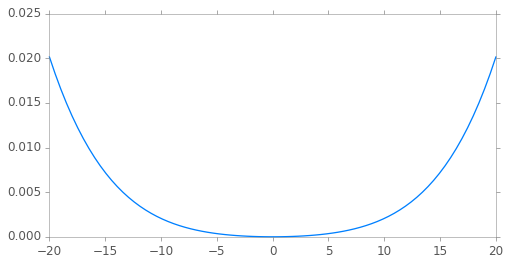

In [19]:
zo = -509.0
f = 25.0
mp = 6.0


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
alphaExact = np.linspace(-20, 20, 80)

alphaApprox = []    
for alpha in alphaExact:
    betaExact = get_beta(zo, f, mp, alpha)
    alphaApprox.append(alpha_approx(zo, f, mp, betaExact))
alphaApprox = np.array(alphaApprox)
err = np.abs(alphaExact - alphaApprox)
relErr = err/np.abs(alphaExact)#
ax.plot(alphaExact, relErr, clip_on=False)

plt.show()

figname: C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\images\approximation_of_lens_tilt.png


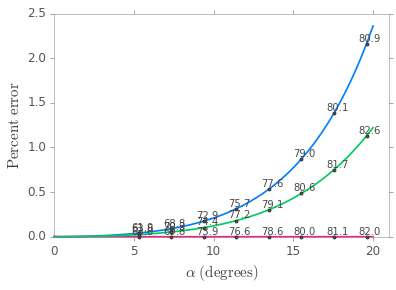

In [45]:
from matplotlib.ticker import FuncFormatter

zo = -509.0
f = 24.0
mpArr = [0.55, 1, 2.0]


fig, ax = plt.subplots(1, 1)
alphaExact = np.linspace(0.0001, 20)

for mp in mpArr:
    alphaApprox = []
    betaArr = []
    for alpha in alphaExact:
        beta = get_beta(zo, f, mp, alpha)
        alphaApprox.append(alpha_approx(zo, f, mp, beta))
        betaArr.append(beta)
    alphaApprox = np.array(alphaApprox)
    err = np.abs(alphaExact - alphaApprox)
    relErr = 100.0*err/np.abs(alphaExact)#
    ax.plot(alphaExact, relErr, lw=1.7, clip_on=False)
    #ax.errorbar(alphaExact, relErr, xerr=0.0, yerr=err, clip_on=False)
    indices = np.argwhere(alphaExact > 5).flatten()[::5]
    ax.scatter(alphaExact[indices], relErr[indices], s=8, clip_on=False, 
               facecolor='#555555', edgecolor=None, zorder=10)
    for i in indices:
        ax.text(x=alphaExact[i]-0.5, y=relErr[i]+0.025, s='{:0.1f}'.format(betaArr[i]))
    
ax.set_ylabel(r'$\rm{Percent}\,\,\rm{error}$', fontsize=15)
ax.set_xlabel(r'$\alpha \,\,\rm(degrees)$', fontsize=15)
ax.set_xlim(alphaExact[0], alphaExact[-1] + 1)
ax.set_ylim(-0.001, 2.5)

#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Save the figure  
saveFigure(fig, 'approximation_of_lens_tilt.png')

plt.show()

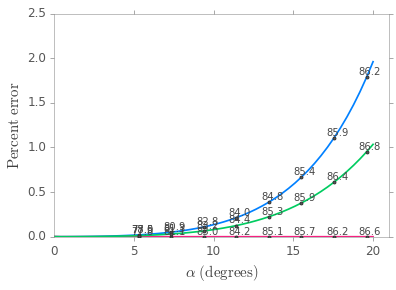

In [21]:
zo = -5009.0
f = 100.0
mpArr = [0.55, 1, 2.0]


fig, ax = plt.subplots(1, 1)
alphaExact = np.linspace(0.0001, 20)

for mp in mpArr:
    alphaApprox = []
    betaArr = []
    for alpha in alphaExact:
        beta = get_beta(zo, f, mp, alpha)
        alphaApprox.append(alpha_approx(zo, f, mp, beta))
        betaArr.append(beta)
    alphaApprox = np.array(alphaApprox)
    err = np.abs(alphaExact - alphaApprox)
    relErr = 100.0*err/np.abs(alphaExact)#
    ax.plot(alphaExact, relErr, lw=1.7, clip_on=True)
    #ax.errorbar(alphaExact, relErr, xerr=0.0, yerr=err, clip_on=False)
    indices = np.argwhere(alphaExact > 5).flatten()[::5]
    ax.scatter(alphaExact[indices], relErr[indices], s=8, clip_on=True, 
               facecolor='#555555', edgecolor=None, zorder=10)
    for i in indices:
        ax.text(x=alphaExact[i]-0.5, y=relErr[i]+0.025, s='{:0.1f}'.format(betaArr[i]))
    
ax.set_ylabel(r'$\rm{Percent}\,\,\rm{error}$', fontsize=15)
ax.set_xlabel(r'$\alpha \,\,\rm(degrees)$', fontsize=15)
ax.set_xlim(alphaExact[0], alphaExact[-1] + 1)
ax.set_ylim(-0.001, 2.5)

#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.show()

In [46]:
fl = 24.0

alphaOpt = 5.0
betaOpt = get_beta(-509.0, fl, 2.0, alphaOpt)
print('beta_opt = ', betaOpt)
t = np.tan(np.deg2rad(betaOpt))

a = fl*mp*t
b = fl*t 
c = fl*(1-mp)/2.0
d = 0/2.0
e = mp*zo/2.0
f = 0

expr = []
alpha = np.linspace(-120, 70, 201)

for each in alpha:
    x = cosd(each)
    y = sind(each)
    expr.append((c*x + b*y + e)/(a*x + c*y + d))

expr = np.array(expr)
    
ct = np.tan(np.deg2rad(alpha))

beta_opt =  62.2296825491


In [48]:
fl = 24.0
alphaOpt = -5.0
zo = -509.0
mp = 2.0
betaOpt = get_beta(zo, fl, mp, alphaOpt)
print('beta_opt = ', betaOpt)
t = np.tan(np.deg2rad(betaOpt))

a = fl*mp*t
b = fl*t 
c = fl*(1-mp)/2.0
d = 0/2.0
e = mp*zo/2.0
f = 0

x = cosd(alphaOpt)
y = sind(alphaOpt)

print(a*x**2 + b*y**2 + 2*c*x*y + 2*d*x + 2*e*y + f)

print(t + sind(alphaOpt)*(mp*zo + fl*(1-mp)*cosd(alphaOpt))/(fl*(mp*cosd(alphaOpt)**2 + sind(alphaOpt)**2)))

beta_opt =  -62.2296825491
-5.68434188608e-14
-4.4408920985e-16


In [51]:
# finding the optimum angle
alpha_thin(zo=-509.0, f=24.0, beta=betaOpt)

-5.1373032521759248

In [459]:
zo = -509.0
f = 24.0   # 100
mp = 0.55
alphaTrue = -15.0

#zo=-539.359427021; f=89.8074019381; mp=0.155474178141; alphaTrue=-6.10160377014;
mp = 0.108342986115; zo = -928.149214632; f = 54.8193565806; alphaTrue = -27.0718326653

beta = get_beta(zo=zo, f=f, mp=mp, alpha=alphaTrue)
alphaInit = alpha_thin(zo=zo, f=f, beta=beta)

print('alpha (true) = ', alphaTrue)
print('beta =', beta)
print('Initial alpha = ', alphaInit)

errValStop = 1e-16
stepThreshold = 10
i = 0
t = tand(beta)
s = sind(alphaInit)
c = cosd(alphaInit)
prevErr = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
#prevErr = beta + arctand(s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))) # Initial merit function value
alpha_i = alphaInit
step = 0.5*prevErr

print("Initial error = ", prevErr)
print("np.arctan(prevErr) = ", np.arctan(prevErr))
print('Initial step = ', step)
print('np.arctan(step) =', np.arctan(step))
print()

while (abs(prevErr) > errValStop) and (i < stepThreshold):
    i += 1
    alpha_i += step 
    s = sind(alpha_i)
    c = cosd(alpha_i)
    err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
    #err = beta + arctand(s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)))
    deltaErr = err - prevErr   
    print('-------------')
    print('err({}) = {:2.4f}'.format(i, err))
    print('deltaErr({}) = {:2.4f}'.format(i, deltaErr))
    print('prevErr({}) = {:2.4f}'.format(i, prevErr))
    print('alpha({}) = {:2.4f}'.format(i, alpha_i))
    if np.sign(err)/np.sign(prevErr) < 0: # modify step direction and possibly size only if i > 0
        step = 0.5*deltaErr
        print('**Sign change: changing step to ', step)
    prevErr = err
    
print('Value of alpha after {} iterations = {:2.5f} (error = {:2.5e}, merit = {:2.5e})'
      .format(i, alpha_i, alphaTrue - alpha_i, err))

alpha (true) =  -27.0718326653
beta = -58.2482831727
Initial alpha =  -5.47655821752
Initial error =  -20.4423265781
np.arctan(prevErr) =  -1.52191717994
Initial step =  -10.2211632891
np.arctan(step) = -1.47327048461

-------------
err(1) = -1.5729
deltaErr(1) = 18.8695
prevErr(1) = -20.4423
alpha(1) = -15.6977
-------------
err(2) = 0.0520
deltaErr(2) = 1.6249
prevErr(2) = -1.5729
alpha(2) = -25.9189
**Sign change: changing step to  0.812442062781
-------------
err(3) = 0.0751
deltaErr(3) = 0.0231
prevErr(3) = 0.0520
alpha(3) = -25.1064
-------------
err(4) = 0.0845
deltaErr(4) = 0.0094
prevErr(4) = 0.0751
alpha(4) = -24.2940
-------------
err(5) = 0.0777
deltaErr(5) = -0.0068
prevErr(5) = 0.0845
alpha(5) = -23.4816
-------------
err(6) = 0.0519
deltaErr(6) = -0.0258
prevErr(6) = 0.0777
alpha(6) = -22.6691
-------------
err(7) = 0.0039
deltaErr(7) = -0.0480
prevErr(7) = 0.0519
alpha(7) = -21.8567
-------------
err(8) = -0.0700
deltaErr(8) = -0.0739
prevErr(8) = 0.0039
alpha(8) = -21.

In [428]:
def estimate_alpha(zo, f, mp, beta, maxSteps=150):
    """
    """
    errValStop = 1e-16
    stepThreshold = maxSteps
    i = 0
    t = tand(beta)
    alphaInit = alpha_thin(zo=zo, f=f, beta=beta)
    s = sind(alphaInit)
    c = cosd(alphaInit)
    prevErr = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
    alpha_i = alphaInit
    step = 0.5*prevErr

    while (abs(prevErr) > errValStop) and (i < stepThreshold):
        i += 1
        alpha_i += step 
        s = sind(alpha_i)
        c = cosd(alpha_i)
        err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
        deltaErr = err - prevErr   
        if np.sign(err)/np.sign(prevErr) < 0: 
            step = 0.5*deltaErr
        prevErr = err
    return alpha_i, i, err

In [455]:
for i in range(6000):
    mp = 0.001 + 4*np.random.random() # problematic
    #mp = 0.2 + 4*np.random.random()  # fine
    zo = -500 - 1000*np.random.random()
    f = 50 + 50*np.random.random()
    alpha = (-1)**np.random.randint(1,3) * 30*np.random.random()
    #
    c = cosd(alpha)
    if mp < f*c/(abs(zo) + f*c):
        break  # the condition is not valid (the consequence is that alpha and beta will not have same sign)
    beta = get_beta(zo=zo, f=f, mp=mp, alpha=alpha)
    # also reject those cases if beta < alpha, because we know that it is not possible
    # (I still need to understand why we get this condition sometimes)
    if abs(beta) < abs(alpha):
        break
    
    if (mp - f*c/(abs(zo) + f*c)) < 0.06:
        print('secondary condition:', mp - f*c/(abs(zo) + f*c))
        #break
        
    alphaEst, numSteps, _ = estimate_alpha(zo=zo, f=f, mp=mp, beta=beta)
    if abs(alpha - alphaEst) > 1e-7:
        print()
        print('mp = {}; zo = {}; f = {}; alpha = {}'.format(mp, zo, f, alpha))
        print('alpha (actual) = {:2.4f}; alpha (est) = {:2.4f}; steps = {}; error = {:2.2e}'
              .format(alpha, alphaEst, numSteps, alpha - alphaEst))
        

secondary condition: 0.0562836567862

mp = 0.101679253101; zo = -1079.87808266; f = 58.416738787; alpha = -28.4685848773
alpha (actual) = -28.4686; alpha (est) = -18.6248; steps = 150; error = -9.84e+00


In [ ]:
# problematic cases found (that still meets the condition):

#
#mp = 0.155474178141; zo = -539.359427021; f = 89.8074019381; alpha = -6.10160377014
#alpha (actual) = -6.1016; alpha (est) = -4.6847; steps = 150; error = -1.42e+00


#
#mp = 0.160118447418; zo = -929.295779676; f = 96.1492470341; alpha = 23.0223723112
#alpha (actual) = 23.0224; alpha (est) = 23.0207; steps = 150; error = 1.67e-03

#
#mp = 0.120164140759; zo = -1133.89717609; f = 84.8370919439; alpha = -27.7399990294
#alpha (actual) = -27.7400; alpha (est) = -27.9950; steps = 150; error = 2.55e-01


#mp = 0.127254588021; zo = -1342.47405012; f = 65.0107548829; alpha = -18.6756216453
#alpha (actual) = -18.6756; alpha (est) = -18.6756; steps = 150; error = 1.45e-05
#

#mp = 0.108342986115; zo = -928.149214632; f = 54.8193565806; alpha = -27.0718326653
#alpha (actual) = -27.0718; alpha (est) = -21.8048; steps = 150; error = -5.27e+00

#
#mp = 0.101679253101; zo = -1079.87808266; f = 58.416738787; alpha = -28.4685848773
#alpha (actual) = -28.4686; alpha (est) = -18.6248; steps = 150; error = -9.84e+00


In [431]:
mp = 0.108342986115; zo = -928.149214632; f = 54.8193565806; alpha = -27.0718326653
estimate_alpha(zo=zo, f=f, mp=mp, beta=beta, maxSteps=150)

(-21.804789584699559, 150, -6.9911096911567938e-07)

In [460]:
# understand the conditions for valid results
#zo=-509.0; f=24.0; mp=0.55; alpha=-15;
#zo=-655.674286325; f=81.6602220572; mp=0.0441952155845; alpha=-14.6948487664;  # invalid condition
#zo=-539.359427021; f=89.8074019381; mp=0.155474178141; alpha=-6.10160377014; # valid condition, but still didn't converge
#zo=-1342.47405012; f=65.0107548829; mp=0.127254588021; alpha=-18.6756216453
#zo=-539.359427021; f=89.8074019381; mp=0.157; alpha=-6.10160377014;
mp = 0.108342986115; zo = -928.149214632; f = 54.8193565806; alpha = -27.0718326653
#mp = 0.101679253101; zo = -1079.87808266; f = 58.416738787; alpha = -28.4685848773

beta = get_beta(zo=zo, f=f, mp=mp, alpha=alpha)
print('alpha =', alpha)
print('beta =', beta)

c = cosd(alpha)
s = sind(alpha)

print('Condition met?', mp > f*c/(abs(zo) + f*c))     # This condition must be satisfied
print(mp - f*c/(abs(zo) + f*c))

print('Secondary condition met?', mp > f/(abs(zo) + f))    
print(mp - f/(abs(zo) + f))

# computation steps for beta
numr = mp*zo + f*(1 - mp)*c
deno = f*(mp*c**2 + s**2)
print('numr =', numr)  # should be negative
print('deno =', deno)  # should be positive
tbeta = -s*numr/deno
print('tbeta =', tbeta)
print(arctand(tbeta))


alpha = -27.0718326653
beta = -58.2482831727
Condition met? True
0.0583787651609
Secondary condition met? True
0.0525738006232
numr = -57.0338572824
deno = 16.0634574502
tbeta = -1.6158737851
-58.2482831727


In [462]:
tand(-60)

-1.7320508075688767